### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F

c:\Users\RONIT\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Reading the dataset

In [2]:
df = pd.read_csv('software_engineer_dataset.csv')
df.head()

,name,resume,degree,field_of_study,GPA,years_of_experience,age,shortlisted
0,Susan Bailey,Susan Bailey is a B.Tech graduate with 1.5 yea...,B.Tech,Computer Science,9.88,1.5,22,0
1,Lauren Cameron DDS,Lauren Cameron DDS is a B.Tech graduate with 4...,B.Tech,Electronics,8.30,4.0,29,1
2,Samantha Hubbard,Samantha Hubbard is a BSc graduate with 6.0 ye...,BSc,Computer Science,6.91,6.0,25,0
3,Michael Johnson,Michael Johnson is a B.Tech graduate with 5.7 ...,B.Tech,Computer Science,8.92,5.7,22,0
4,Dominique Sanchez,Dominique Sanchez is a B.Tech graduate with 2....,B.Tech,Electronics,6.42,2.0,30,0


# 1. Data Preprocessing

### Text Processing
I have used BERT tokenizer to process the resume text with max length 256

In [3]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_text(texts, tokenizer, max_length=256):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids.append(encoded['input_ids'].flatten())
        attention_masks.append(encoded['attention_mask'].flatten())

    return torch.stack(input_ids), torch.stack(attention_masks)

input_ids, attention_masks = preprocess_text(df['resume'], tokenizer)
print(f"Text preprocessing complete. Input IDs shape: {input_ids.shape}, Attention masks shape: {attention_masks.shape}")

Text preprocessing complete. Input IDs shape: torch.Size([1000, 256]), Attention masks shape: torch.Size([1000, 256])


### Tabular Features 
Here I have handled tabular features which itself is divided into two parts:
* Categorical Features: degree, field_of_study
* Numerical Features: GPA, years_of_experience, age

I have used Label encoding for categorical features and Standard scaler for numerical features.

In [4]:
def preprocess_tabular_features(df):
    df_processed = df.copy()

    categorical_cols = ['degree', 'field_of_study']
    numerical_cols = ['GPA', 'years_of_experience', 'age']

    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[col+'_encoded'] = le.fit_transform(df_processed[col])
        label_encoders[col] = le
    print(f"Categorical columns encoded: {categorical_cols}")

    scalers = {}
    for col in numerical_cols:
        scaler = StandardScaler()
        df_processed[col+'_scaled'] = scaler.fit_transform(df_processed[[col]])
        scalers[col] = scaler
    print(f"Numerical columns scaled: {numerical_cols}")

    return df_processed, label_encoders, scalers, categorical_cols, numerical_cols

df_processed, label_encoders, scalers, categorical_cols, numerical_cols = preprocess_tabular_features(df)
print(f"Tabular feature preprocessing complete. Processed DataFrame shape: {df_processed.shape}")

Categorical columns encoded: ['degree', 'field_of_study']
Numerical columns scaled: ['GPA', 'years_of_experience', 'age']
Tabular feature preprocessing complete. Processed DataFrame shape: (1000, 13)


In [5]:
def create_tabular_features(df_processed, categorical_cols, numerical_cols):
    feature_columns = []
    for col in categorical_cols:
        feature_columns.append(col+'_encoded')
    for col in numerical_cols:
        feature_columns.append(col+'_scaled')

    X_tabular = df_processed[feature_columns].values
    print(f"Tabular features created with shape: {X_tabular.shape}")
    print(f"Feature columns: {feature_columns}")

    return torch.FloatTensor(X_tabular), feature_columns

X_tabular, feature_columns = create_tabular_features(df_processed, categorical_cols, numerical_cols)

Tabular features created with shape: (1000, 5)
Feature columns: ['degree_encoded', 'field_of_study_encoded', 'GPA_scaled', 'years_of_experience_scaled', 'age_scaled']


### Data Splitting:
Here I have splitted data into 3 parts
* Train dataset ($70\%$)
* Validation dataset ($15\%$)
* Test dataset ($15\%$).

I have also made sure to avoid class imbalance in any dataset.

In [6]:
def create_stratified_splits(input_ids, attention_masks, X_tabular, y, test_size = 0.3, val_size = 0.5, random_state=42):
    train_ratio = 1-test_size
    indices = np.arange(len(y))

    train_idx, temp_idx = train_test_split(
        indices,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    temp_y = y[temp_idx]
    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=val_size,
        random_state=random_state,
        stratify=temp_y
    )

    train_input_ids = input_ids[train_idx]
    train_attention_masks = attention_masks[train_idx]
    train_tabular = X_tabular[train_idx]
    train_labels = torch.FloatTensor(y[train_idx])

    val_input_ids = input_ids[val_idx]
    val_attention_masks = attention_masks[val_idx]
    val_tabular = X_tabular[val_idx]
    val_labels = torch.FloatTensor(y[val_idx])

    test_input_ids = input_ids[test_idx]
    test_attention_masks = attention_masks[test_idx]
    test_tabular = X_tabular[test_idx]
    test_labels = torch.FloatTensor(y[test_idx])

    print(f"Train set: {len(train_labels)} samples")
    print(f"Validation set: {len(val_labels)} samples")
    print(f"Test set: {len(test_labels)} samples")

    print(f"\nTrain class distribution: {train_labels.sum().item()}/{len(train_labels)} positive")
    print(f"Val class distribution: {val_labels.sum().item()}/{len(val_labels)} positive")
    print(f"Test class distribution: {test_labels.sum().item()}/{len(test_labels)} positive")

    return {
        'train': (train_input_ids, train_attention_masks, train_tabular, train_labels),
        'val': (val_input_ids, val_attention_masks, val_tabular, val_labels),
        'test': (test_input_ids, test_attention_masks, test_tabular, test_labels)
    }

y = df['shortlisted'].values
data_splits = create_stratified_splits(input_ids, attention_masks, X_tabular, y)

Train set: 700 samples
Validation set: 150 samples
Test set: 150 samples

Train class distribution: 209.0/700 positive
Val class distribution: 45.0/150 positive
Test class distribution: 44.0/150 positive


### 2. Model Architecture (MultimodalResumeClassifier)
* Text Branch: Pre-trained BERT-base-uncased for resume text
* Tabular Branch: Neural network with batch normalization and dropout
* Fusion Layer: Concatenates text and tabular features
* Output: Binary classification for resume shortlisting

In [7]:
class MultimodalResumeClassifier(nn.Module):
    def __init__(
            self,
            bert_model_name = 'bert-base-uncased',
            tabular_input_dim = 5,
            bert_hidden_dim = 768,
            tabular_hidden_dim = 128,
            fusion_hidden_dim = 256,
            dropout_rate = 0.3,
            num_classes = 1
    ):
        super(MultimodalResumeClassifier, self).__init__()

        self.bert = AutoModel.from_pretrained(bert_model_name)

        self.tabular_encoder = nn.Sequential(
            nn.Linear(tabular_input_dim, tabular_hidden_dim),
            nn.BatchNorm1d(tabular_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(tabular_hidden_dim, tabular_hidden_dim // 2),
            nn.BatchNorm1d(tabular_hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        fusion_input_dim = bert_hidden_dim + (tabular_hidden_dim // 2)
        self.fusion_layer = nn.Sequential(
            nn.Linear(fusion_input_dim, fusion_hidden_dim),
            nn.BatchNorm1d(fusion_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(fusion_hidden_dim, fusion_hidden_dim // 2),
            nn.BatchNorm1d(fusion_hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        self.classifier = nn.Sequential(
            nn.Linear(fusion_hidden_dim // 2, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes)  # Output logits (raw scores)
        )

    def forward(self, input_ids, attention_masks, tabular_features):
        bert_outputs = self.bert(input_ids, attention_masks)
        text_features = bert_outputs.pooler_output
        tabular_encoded = self.tabular_encoder(tabular_features)
        fused_features = torch.cat([text_features, tabular_encoded], dim =1)
        fused_output = self.fusion_layer(fused_features)
        logits = self.classifier(fused_output)

        return logits.squeeze(-1)

In [9]:
model = MultimodalResumeClassifier(
    tabular_input_dim=X_tabular.shape[1],
    dropout_rate=0.3
)

### Forward pass for sample input

In [10]:
def test_model_forward_pass():
    batch_size = 4
    train_input_ids, train_attention_masks, train_tabular, train_labels = data_splits['train']

    sample_input_ids = train_input_ids[:batch_size]
    sample_attention_masks = train_attention_masks[:batch_size]
    sample_tabular = train_tabular[:batch_size]
    sample_labels = train_labels[:batch_size]

    model.eval()
    with torch.no_grad():
        logits = model(sample_input_ids, sample_attention_masks, sample_tabular)
        probabilities = torch.sigmoid(logits)
        predictions = (probabilities > 0.5).float()

    print(f"\nModel outputs:")
    print(f"Logits: {logits}")
    print(f"Probabilities: {probabilities}")
    print(f"Predictions: {predictions}")
    print(f"True labels: {sample_labels}")

    return True

test_success = test_model_forward_pass()


Model outputs:
Logits: tensor([-0.0360, -0.0398, -0.0366, -0.0356])
Probabilities: tensor([0.4910, 0.4901, 0.4908, 0.4911])
Predictions: tensor([0., 0., 0., 0.])
True labels: tensor([1., 0., 1., 0.])


### Creating dataset and dataloader

In [11]:
from torch.utils.data import Dataset, DataLoader

class ResumeDataset(Dataset):
    def __init__(self, input_ids, attention_masks, tabular_features, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.tabular_features = tabular_features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'tabular_features': self.tabular_features[idx],
            'labels': self.labels[idx]
        }

train_dataset = ResumeDataset(*data_splits['train'])
val_dataset = ResumeDataset(*data_splits['val'])
test_dataset = ResumeDataset(*data_splits['test'])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Data loaders created:")
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Data loaders created:
Train batches: 44
Validation batches: 10
Test batches: 10


### Training parameters:
* Optimization: AdamW optimizer with Cosine Annealing scheduler
* Regularization: Dropout (0.3), gradient clipping, early stopping
* Loss Function: BCEWithLogitsLoss for binary classification

In [12]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import time
from tqdm import tqdm

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr = 2e-5, weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-7)

In [13]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_predictions = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc="Training")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        tabular_features = batch['tabular_features'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        logits = model(input_ids, attention_mask, tabular_features)
        loss = criterion(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        predictions = torch.sigmoid(logits) > 0.5
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    return avg_loss, accuracy, f1

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_probabilities = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            tabular_features = batch['tabular_features'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask, tabular_features)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            probabilities = torch.sigmoid(logits)
            predictions = probabilities > 0.5

            all_predictions.extend(predictions.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions, zero_division=0)
    f1 = f1_score(all_labels, all_predictions, zero_division=0)

    try:
        auc = roc_auc_score(all_labels, all_probabilities)
    except:
        auc = 0.0

    return avg_loss, accuracy, precision, recall, f1, auc

### Class for early stopping

In [14]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_score = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_score, model):
        if self.best_score is None:
            self.best_score = val_score
            self.save_checkpoint(model)
        elif val_score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                if self.restore_best_weights:
                    model.load_state_dict(self.best_weights)
                return True
        else:
            self.best_score = val_score
            self.counter = 0
            self.save_checkpoint(model)
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

early_stopping = EarlyStopping(patience=5, min_delta=0.001)

In [15]:
import joblib
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(scalers, 'scalers.pkl')

['scalers.pkl']

### Training model

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                device, num_epochs=25, early_stopping=None):

    model = model.to(device)

    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_precision': [],
        'val_recall': [], 'val_f1': [], 'val_auc': []
    }

    best_val_f1 = 0

    for epoch in range(num_epochs):
        train_loss, train_acc, train_f1 = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_precision, val_recall, val_f1, val_auc = validate_epoch(model, val_loader, criterion, device)

        scheduler.step()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)
        history['val_auc'].append(val_auc)

        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pth')

        # Early stopping
        if early_stopping:
            if early_stopping(val_f1, model):
                break

        print(f"Epoch {epoch + 1}/{num_epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return model, history

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=25,
    early_stopping=early_stopping
)

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:04<?, ?it/s]


KeyboardInterrupt: 

### After training comments:
* After 21 epochs we got best train accuracy of $88.29\%$ and validation accuracy of $79.33\%$
* I have also plotted loss and accuracy plot over the epochs

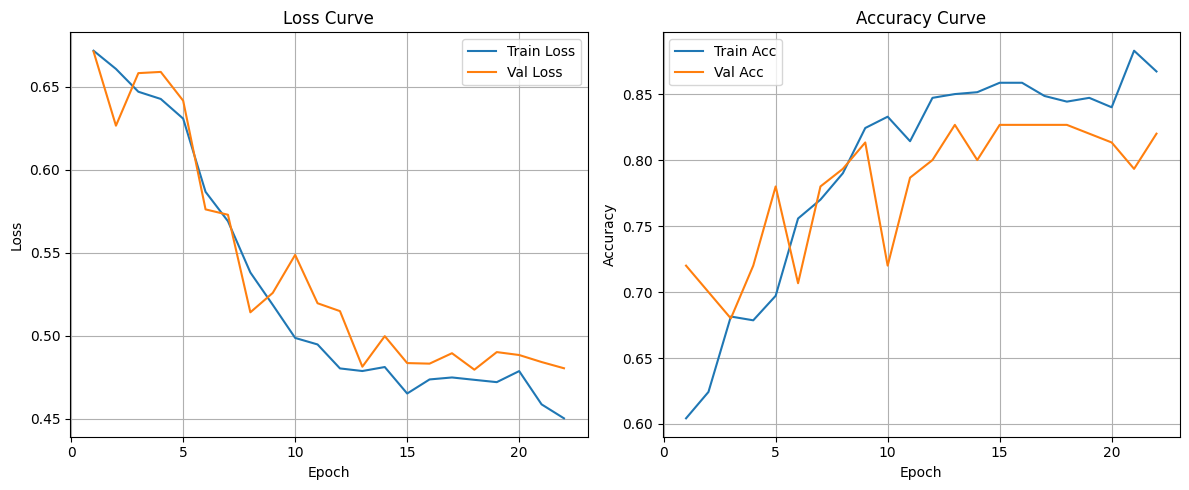

In [34]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

### 4. Evaluation
* Comprehensive metrics: Accuracy, Precision, Recall, F1-Score, AUC
* Training history visualization
* Best model checkpointing

In [ ]:
def test_model(model, test_loader, device):
    """Evaluate model on test set for final performance"""
    model.eval()
    all_predictions = []
    all_probabilities = []
    all_labels = []


    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            tabular_features = batch['tabular_features'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask, tabular_features)
            probabilities = torch.sigmoid(logits)
            predictions = probabilities > 0.5

            all_predictions.extend(predictions.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate final test metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions, zero_division=0)
    f1 = f1_score(all_labels, all_predictions, zero_division=0)
    auc = roc_auc_score(all_labels, all_probabilities)

    print("\n" + "="*50)
    print("="*50)
    print(f"Test Accuracy:  {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall:    {recall:.4f}")
    print(f"Test F1-Score:  {f1:.4f}")
    print(f"Test AUC:       {auc:.4f}")
    print("="*50)

    return {
        'test_accuracy': accuracy,
        'test_precision': precision,
        'test_recall': recall,
        'test_f1': f1,
        'test_auc': auc,
        'predictions': all_predictions,
        'probabilities': all_probabilities,
        'true_labels': all_labels
    }

# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_model.pth'))
test_results = test_model(model, test_loader, device)

Testing: 100%|██████████| 10/10 [00:02<00:00,  4.68it/s]


Test Accuracy:  0.7667
Test Precision: 0.5570
Test Recall:    1.0000
Test F1-Score:  0.7154
Test AUC:       0.9331


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [22]:
X = df_processed[feature_columns].values
y = df_processed['shortlisted'].values

scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[:, -len(numerical_cols):] = scaler.fit_transform(X[:, -len(numerical_cols):])


In [23]:
from sklearn.model_selection import train_test_split

# First split: 70% train, 30% temp (which will be split into 15% val, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: Split temp into validation and test (50-50, so 15% each of original)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [25]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000, 2000]
}

param_grid_elasticnet = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_iter': [1000, 2000]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [1000, 2000],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['liblinear', 'saga']},
             scoring='f1', verbose=1)

In [26]:
grid_search_elastic = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid_elasticnet,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_elastic.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
                         'max_iter': [1000, 2000], 'penalty': ['elasticnet'],
                         'solver': ['saga']},
             scoring='f1', verbose=1)

In [27]:
if grid_search.best_score_ > grid_search_elastic.best_score_:
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_cv_score = grid_search.best_score_
else:
    best_model = grid_search_elastic.best_estimator_
    best_params = grid_search_elastic.best_params_
    best_cv_score = grid_search_elastic.best_score_

print(f"\nBest parameters: {best_params}")
print(f"Best cross-validation F1 score: {best_cv_score:.4f}")


Best parameters: {'C': 10, 'l1_ratio': 0.3, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'}
Best cross-validation F1 score: 0.4796


In [28]:
y_val_pred = best_model.predict(X_val)
y_val_proba = best_model.predict_proba(X_val)[:, 1]

val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_proba)

print(f"\nValidation Results:")
print(f"Accuracy:  {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall:    {val_recall:.4f}")
print(f"F1-Score:  {val_f1:.4f}")
print(f"AUC:       {val_auc:.4f}")


Validation Results:
Accuracy:  0.7200
Precision: 0.5484
Recall:    0.3778
F1-Score:  0.4474
AUC:       0.7771


In [29]:
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"\n" + "="*60)
print("FINAL TEST RESULTS - LOGISTIC REGRESSION (TABULAR ONLY)")
print("="*60)
print(f"Test Accuracy:  {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test F1-Score:  {test_f1:.4f}")
print(f"Test AUC:       {test_auc:.4f}")
print("="*60)


FINAL TEST RESULTS - LOGISTIC REGRESSION (TABULAR ONLY)
Test Accuracy:  0.7600
Test Precision: 0.6429
Test Recall:    0.4091
Test F1-Score:  0.5000
Test AUC:       0.8302
